# Published Items for the Center for Health AI

This takes a list of authors and searches for any items published this year, grabs the proper citation from manubot-cite, and creates a markdown and MS Word document.

This isn't a replacement for a proper data pipeline. Just a demo to see if the selection logic is sound.

2021/12/20 stephen.taylor@cuanschutz.edu First demo
2022/01/18 stephen.taylor@cuanschutz.edu Fetch pubmed instead of PMC ids

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import json
import logging
import manubot
import requests
import pandas as pd
import subprocess

from manubot.cite.citations import Citations

from datetime import date
from ratelimit import limits, RateLimitException, sleep_and_retry

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

BUILD_FOLDER = "_build"

<IPython.core.display.Javascript object>

In [3]:
# These can be used as arguments via papermill

# Looking at this year's items
THIS_YEAR = 2021

# If you have an NCBI API key, enter it here
API_KEY = "6f104848ae7ff47f67a69b6b0df250392608"

# For testing, set a sample size between 0 and 1.0
SAMPLE_FRACTION = 1.0

<IPython.core.display.Javascript object>

In [4]:
# We get faster NCBI rates if we use a key.
if API_KEY:
    NCBI_RATE_LIMIT = 10
else:
    NCBI_RATE_LIMIT = 3

NCBI_RATE_LIMIT

10

<IPython.core.display.Javascript object>

In [5]:
# will write out to a folder
if not os.path.exists(BUILD_FOLDER):
    os.makedirs(BUILD_FOLDER)

<IPython.core.display.Javascript object>

In [6]:
# Read in the authors and their specific search terms
authors_df = pd.read_json("authors.json", orient="index")
authors_df

,author_type,search_term
Aquilante C,contributor,(Aquilante C[Author])
Barnes K,contributor,(Barnes K[Author])
Boorgula M,contributor,(Boorgula M[Author])
Brooks I,contributor,(Brooks I[Author])
Campbell M,contributor,(Campbell M[Author])
Casey Greene,pi,(Casey Greene)
Claw K,contributor,(Claw K[Author])
Cohen M,contributor,(Cohen M[Author])
Coors M,contributor,(Coors M[Author])
Crooks K,contributor,(Crooks K[Author])


<IPython.core.display.Javascript object>

In [7]:
# for testing it's nice to take a sample
if 0 < SAMPLE_FRACTION < 1.0:
    authors_df = authors_df.sample(frac=SAMPLE_FRACTION)

<IPython.core.display.Javascript object>

In [8]:
# convert into a dict
author_records = authors_df.to_dict("index")
author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '(Aquilante C[Author])'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '(Barnes K[Author])'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '(Boorgula M[Author])'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '(Brooks I[Author])'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '(Campbell M[Author])'},
 'Casey Greene': {'author_type': 'pi', 'search_term': '(Casey Greene)'},
 'Claw K': {'author_type': 'contributor', 'search_term': '(Claw K[Author])'},
 'Cohen M': {'author_type': 'contributor', 'search_term': '(Cohen M[Author])'},
 'Coors M': {'author_type': 'contributor', 'search_term': '(Coors M[Author])'},
 'Crooks K': {'author_type': 'contributor',
  'search_term': '(Crooks K[Author])'},
 'Fingerlin T': {'author_type': 'contributor',
  'search_term': '(Fingerlin T[Author])'},
 'Fishbein L': {'author_type': 'contributor',
  'search_term': '(Fishbein L[Autho

<IPython.core.display.Javascript object>

In [9]:
# modify search terms, e.g., contributors are filtered by CU or CCPM
for k, v in author_records.items():

    # Restrict contributors to CU items
    if v["author_type"] == "contributor":
        v[
            "search_term"
        ] = f"({v['search_term']} AND ((\"University of Colorado\") OR (\"Colorado Center for Personalized Medicine\")))"

author_records

{'Aquilante C': {'author_type': 'contributor',
  'search_term': '((Aquilante C[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Barnes K': {'author_type': 'contributor',
  'search_term': '((Barnes K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Boorgula M': {'author_type': 'contributor',
  'search_term': '((Boorgula M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Brooks I': {'author_type': 'contributor',
  'search_term': '((Brooks I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Campbell M': {'author_type': 'contributor',
  'search_term': '((Campbell M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))'},
 'Casey Greene': {'author_type': 'pi', 'search_term': '(Casey Greene)'},
 'Claw K': {'author_type': 'contributor',
  'search_term': '((Claw K[Auth

<IPython.core.display.Javascript object>

In [10]:
@sleep_and_retry
@limits(calls=NCBI_RATE_LIMIT, period=60)
def search_ncbi(term, start_year, api_key=None, email="Stephen.Taylor@cuanschutz.edu"):
    """
    Look up IDs given a search term,
    a beginning year, and an optional API key.

    NCBI asks that we use an API key,
    which increases API calls to 10/minute, instead of 3/minute.

    Returns a list of IDs
    """
    ids = []

    params = {
        "term": term,
        "format": "pmid",
        "tool": "CUAnschutz-Center_for_Health_AI-DEV",
        "email": email,
        "format": "json",
        "retmax": 100,
        "retstart": 0,
        "mindate": f"{start_year}/01/01",
        "maxdate": f"{start_year}/12/31",
    }

    if api_key:
        params["api_key"] = api_key

    # page through the results until there are no more ids
    while True:
        r = requests.get(
            "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi", params
        )
        if r.status_code == 200:
            result = r.json()["esearchresult"]
        else:
            logging.error(f"NCBI returned a status code of {r.status_code}.")
            break

        if len(result["idlist"]) == 0:
            # no more IDs
            break
        else:
            # append the IDs to the results...
            ids = ids + result["idlist"]
            # and move the start chunk up by the size of retmax
            params["retstart"] += params["retmax"]

    return ids

<IPython.core.display.Javascript object>

In [11]:
# I would like to do this in parallel, but the deal with NCBI is we agree not to do that
id_dict = {}
for author, v in author_records.items():
    logging.info(f"Looking up `{author}` using {v['search_term']}")
    ids = search_ncbi(term=v["search_term"], start_year=THIS_YEAR, api_key=API_KEY)

    for id in ids:
        if not id_dict.get(id):
            # create an empty nested dict
            id_dict[id] = {"authors": []}
        id_dict[id]["authors"].append(author)

id_dict

INFO:root:Looking up `Aquilante C` using ((Aquilante C[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Barnes K` using ((Barnes K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Boorgula M` using ((Boorgula M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Brooks I` using ((Brooks I[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Campbell M` using ((Campbell M[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Casey Greene` using (Casey Greene)
INFO:root:Looking up `Claw K` using ((Claw K[Author]) AND (("University of Colorado") OR ("Colorado Center for Personalized Medicine")))
INFO:root:Looking up `Cohen M` using ((Cohen M[Author]) AND (("University of Colorado")

{'34562070': {'authors': ['Aquilante C']},
 '34331322': {'authors': ['Aquilante C']},
 '34282303': {'authors': ['Aquilante C']},
 '34253456': {'authors': ['Aquilante C']},
 '33868389': {'authors': ['Aquilante C']},
 '33772264': {'authors': ['Aquilante C', 'Lee YM']},
 '33657875': {'authors': ['Aquilante C', 'Lee YM']},
 '33650294': {'authors': ['Aquilante C', 'Gignoux C', 'Shortt J']},
 '33549348': {'authors': ['Aquilante C']},
 '33428770': {'authors': ['Aquilante C', 'Kao D', 'Wiley L']},
 '34780848': {'authors': ['Barnes K',
   'Campbell M',
   'Johnson RK',
   'Mathias R',
   'Reisdorph N']},
 '34762840': {'authors': ['Barnes K']},
 '34582791': {'authors': ['Barnes K', 'Boorgula M', 'Lange L', 'Mathias R']},
 '34536413': {'authors': ['Barnes K',
   'Boorgula M',
   'Campbell M',
   'Mathias R']},
 '34385354': {'authors': ['Barnes K']},
 '34111454': {'authors': ['Barnes K',
   'Boorgula M',
   'Campbell M',
   'Gignoux C',
   'Mathias R']},
 '34104797': {'authors': ['Barnes K']},
 '3

<IPython.core.display.Javascript object>

How many items found?

In [12]:
len(id_dict)

338

<IPython.core.display.Javascript object>

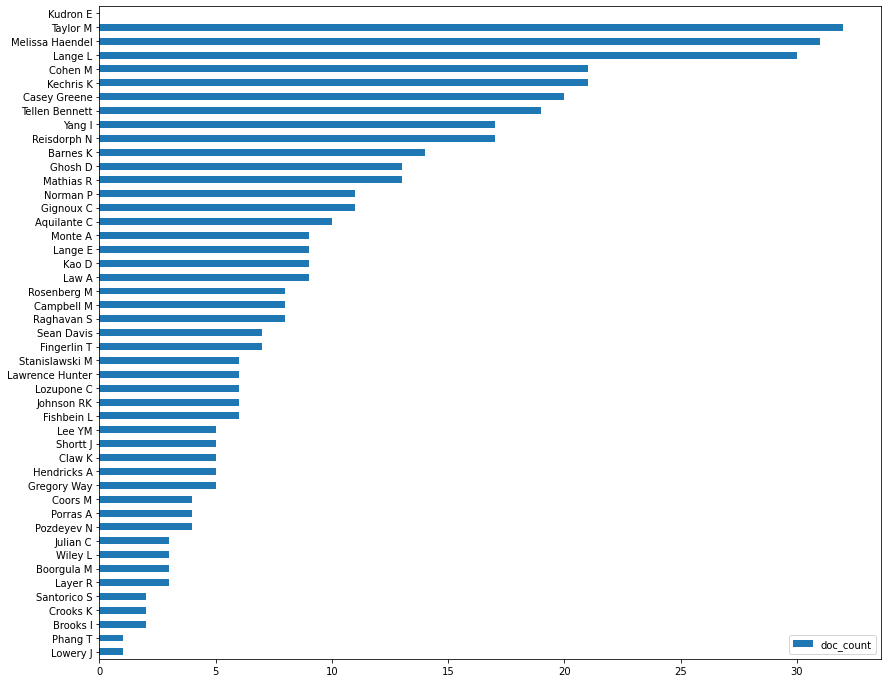

<IPython.core.display.Javascript object>

In [13]:
# useful to get a handle on the shape of the data
doc_count = {}
for k, v in id_dict.items():
    for author in v["authors"]:
        if not doc_count.get(author):
            doc_count[author] = 0
        doc_count[author] += 1

authors_df["doc_count"] = pd.Series(doc_count)
ax = authors_df.sort_values(by="doc_count").plot.barh(figsize=(14, 12))
fig = ax.get_figure()
fig.savefig(os.path.join(BUILD_FOLDER, "author_items.png"))

In [18]:
# Retrive the references from manubot
keys = [k for k in id_dict]
citations = Citations(keys)
cites = citations.get_csl_items()
cites[0]

{'title': 'Barriers and Considerations for Diagnosing Rare Diseases in Indigenous Populations.',
 'volume': '8',
 'page': '579924',
 'container-title': 'Frontiers in pediatrics',
 'container-title-short': 'Front Pediatr',
 'ISSN': '2296-2360',
 'issued': {'date-parts': [[2020, 12, 14]]},
 'author': [{'given': 'Carla S', 'family': "D'Angelo"},
  {'given': 'Azure', 'family': 'Hermes'},
  {'given': 'Christopher R', 'family': 'McMaster'},
  {'given': 'Elissa', 'family': 'Prichep'},
  {'given': 'Étienne', 'family': 'Richer'},
  {'given': 'Francois H', 'family': 'van der Westhuizen'},
  {'given': 'Gabriela M', 'family': 'Repetto'},
  {'given': 'Gong', 'family': 'Mengchun'},
  {'given': 'Helen', 'family': 'Malherbe'},
  {'given': 'Juergen K V', 'family': 'Reichardt'},
  {'given': 'Laura', 'family': 'Arbour'},
  {'given': 'Maui', 'family': 'Hudson'},
  {'given': 'Kelly', 'family': 'du Plessis'},
  {'given': 'Melissa', 'family': 'Haendel'},
  {'given': 'Phillip', 'family': 'Wilcox'},
  {'given'

<IPython.core.display.Javascript object>

In [20]:
# I'm going to want to sort these later.
for rec in cites:
    key = rec["PMID"]

    id_dict[key]["csljson"] = rec
    id_dict[key]["title"] = rec["title"].strip()

    # all this for the date!
    if rec.get("issued"):
        issued_date_parts = rec["issued"]["date-parts"][0]
        date_str = str(issued_date_parts[0])
        try:
            date_str += f"/{issued_date_parts[1]}"
            try:
                date_str += f"/{issued_date_parts[2]}"
            except:
                pass
        except:
            pass

        id_dict[key]["issued_date"] = date_str

<IPython.core.display.Javascript object>

In [21]:
# sort the dictionary by title
df = pd.DataFrame.from_dict(id_dict, orient="index")
df.sort_values(by="title", inplace=True)
df

,authors,csljson,title,issued_date
33629880,[Cohen M],"{'title': '""Death Diamond"" Tracing on Thromboe...","""Death Diamond"" Tracing on Thromboelastography...",2021/2/25
34758253,[Melissa Haendel],"{'title': '100,000 Genomes Pilot on Rare-Disea...","100,000 Genomes Pilot on Rare-Disease Diagnosi...",2021/11/11
34245921,[Crooks K],{'title': 'A Curriculum for Genomic Education ...,A Curriculum for Genomic Education of Molecula...,2021/7/7
33960013,[Sean Davis],{'title': 'A Floating Mold Technique for the P...,A Floating Mold Technique for the Programmed A...,2021/5/7
34436483,"[Johnson RK, Kechris K, Yang I]",{'title': 'A Mediation Approach to Discovering...,A Mediation Approach to Discovering Causal Rel...,2021/8/14
...,...,...,...,...
34582791,"[Barnes K, Boorgula M, Lange L, Mathias R]",{'title': 'Whole-genome sequencing in diverse ...,Whole-genome sequencing in diverse subjects id...,2021/9/27
34216016,[Taylor M],{'title': 'ZMYND11 variants are a novel cause ...,ZMYND11 variants are a novel cause of centrote...,2021/7/16
33997407,"[Barnes K, Campbell M, Crooks K]",{'title': 'Zika Virus Congenital Syndrome and ...,Zika Virus Congenital Syndrome and,2021/4/22
34428202,[Casey Greene],{'title': 'miQC: An adaptive probabilistic fra...,miQC: An adaptive probabilistic framework for ...,2021/8/24


<IPython.core.display.Javascript object>

In [22]:
def get_markdown(id):
    """
    This version gets a single cite per ID.
    """
    logging.info(f"Creating cite reference for {id}.")

    # Use manubot-cite to fetch the formatted citation
    args = ["manubot", "cite", "--format=markdown", f"pubmed:{id}"]

    process = subprocess.run(
        args=args,
        encoding="utf-8",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    # process.check_returncode()
    assert process.returncode == 0

    # cite has the index number stripped out.
    return {
        "id": id,
        "cite": process.stdout,
    }

# create a list of pubmed ids for manubot-cite
ids = [f"pubmed:{x}" for x in df.index.to_list()]

# get cites, admittedly the long way round.
my_list = []
for id in df.index.to_list():
    my_list.append(get_markdown(id))
my_list

INFO:root:Creating cite reference for 33629880.
INFO:root:Creating cite reference for 34758253.
INFO:root:Creating cite reference for 34245921.
INFO:root:Creating cite reference for 33960013.
INFO:root:Creating cite reference for 34436483.
INFO:root:Creating cite reference for 34549274.
INFO:root:Creating cite reference for 33467846.
INFO:root:Creating cite reference for 34953578.
INFO:root:Creating cite reference for 33568809.
INFO:root:Creating cite reference for 34618807.
INFO:root:Creating cite reference for 34611218.
INFO:root:Creating cite reference for 34354225.
INFO:root:Creating cite reference for 33883556.
INFO:root:Creating cite reference for 34849255.
INFO:root:Creating cite reference for 33616658.
INFO:root:Creating cite reference for 34108994.
INFO:root:Creating cite reference for 34283786.
INFO:root:Creating cite reference for 34318925.
INFO:root:Creating cite reference for 34706968.
INFO:root:Creating cite reference for 33828220.
INFO:root:Creating cite reference for 34

INFO:root:Creating cite reference for 34769463.
INFO:root:Creating cite reference for 34907787.
INFO:root:Creating cite reference for 33664984.
INFO:root:Creating cite reference for 34677393.
INFO:root:Creating cite reference for 34874889.
INFO:root:Creating cite reference for 33789113.
INFO:root:Creating cite reference for 33986121.
INFO:root:Creating cite reference for 34284445.
INFO:root:Creating cite reference for 33783586.
INFO:root:Creating cite reference for 34024500.
INFO:root:Creating cite reference for 34174557.
INFO:root:Creating cite reference for 33636116.
INFO:root:Creating cite reference for 34572260.
INFO:root:Creating cite reference for 34672390.
INFO:root:Creating cite reference for 34161761.
INFO:root:Creating cite reference for 33826903.
INFO:root:Creating cite reference for 33799786.
INFO:root:Creating cite reference for 34047639.
INFO:root:Creating cite reference for 34304293.
INFO:root:Creating cite reference for 34919694.
INFO:root:Creating cite reference for 34

[{'id': '33629880',
  'cite': '1. **“Death Diamond” Tracing on Thromboelastography as a Marker of Poor Survival After Trauma.**\nMichael S Farrell, Ernest E Moore, Anthony V Thomas, Julia R Coleman, Scott Thomas, Stefani Vande Lune, Thomas Marconi, Mitchell J Cohen, Michael P Chapman, Hunter B Moore, … Sherry Sixta *The American surgeon* (2021-02-25) <https://www.ncbi.nlm.nih.gov/pubmed/33629880>\nDOI: [10.1177/0003134821998684](https://doi.org/10.1177/0003134821998684) · PMID: [33629880](https://www.ncbi.nlm.nih.gov/pubmed/33629880)\n'},
 {'id': '34758253',
  'cite': '1. **100,000 Genomes Pilot on Rare-Disease Diagnosis in Health Care - Preliminary Report.**\n, Damian Smedley, Katherine R Smith, Antonio Martin, Ellen A Thomas, Ellen M McDonagh, Valentina Cipriani, Jamie M Ellingford, Gavin Arno, Arianna Tucci, … Mark Caulfield *The New England journal of medicine* (2021-11-11) <https://www.ncbi.nlm.nih.gov/pubmed/34758253>\nDOI: [10.1056/nejmoa2035790](https://doi.org/10.1056/nejmoa20

<IPython.core.display.Javascript object>

Build up the markdown

In [28]:
image_path = os.path.abspath(os.path.join(BUILD_FOLDER, "author_items.png"))

# Windows paths. Switch the slashes over if windows
image_path = image_path.replace("\\", "/")

with open(os.path.join(BUILD_FOLDER, "cites.md"), "w", encoding="utf-8") as f:
    f.write(f"# Center for Health AI, Published Items {THIS_YEAR}\n\n")

    f.write(f"## Author Item Counts\n\n")
    f.write(f"![]({image_path})\n\n")

    f.write(f"## Published Items Citations\n\n")
    for rec in my_list:
        f.write(rec["cite"])
        f.write("\n")

<IPython.core.display.Javascript object>

In [30]:
# convert markdown to Microsoft Word
args = [
    "pandoc",
    "-s",
    os.path.join(BUILD_FOLDER, "cites.md"),
    "-o",
    os.path.join(BUILD_FOLDER, "cites.docx"),
]

process = subprocess.run(
    args=args,
    encoding="utf-8",
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

assert process.returncode == 0

<IPython.core.display.Javascript object>